In [99]:
#list of Import

import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from PIL import Image, ImageFile 
import time
from collections import OrderedDict 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models


import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

import Helper

In [58]:
#data loader

data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_datasets = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_datasets = datasets.ImageFolder(data_dir + '/test', transform=valid_transforms)
test_datasets = datasets.ImageFolder(data_dir + '/train', transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
validloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_datasets, batch_size=64, shuffle=True)

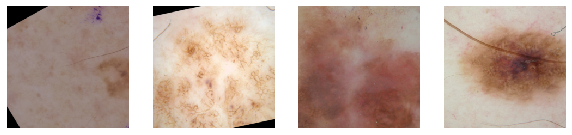

In [59]:
data_iter = iter(trainloaders)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    Helper.imshow(images[ii], ax=ax)

In [86]:
data_dir = 'data/'

train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

image_datasets = {x: datasets.ImageFolder(data_dir + x, transform = train_transforms) for x in ['train', 'valid', 'test']}

loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}


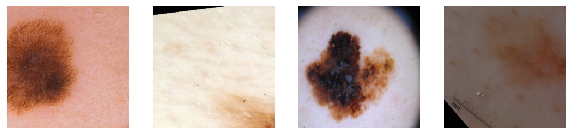

In [87]:
data_iter = iter(loaders_scratch['train'])

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    Helper.imshow(images[ii], ax=ax)

In [93]:
data_dir = 'data/'

train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

image_datasets_2 = {x: datasets.ImageFolder(data_dir + x, transform = train_transforms if x == 'train' else valid_transforms if x == 'valid' else test_transforms) for x in ['train', 'valid', 'test']}

loaders_scratch_2 = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}


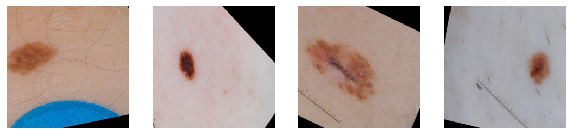

In [95]:
data_iter = iter(loaders_scratch_2['valid'])

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    Helper.imshow(images[ii], ax=ax)

In [114]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler) 

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_transfer.state_dict(), 'model_augmented.pt')
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [115]:
model_transfer = models.vgg16(pretrained=True)

print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 3 type)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 3)

model_transfer.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()

4096
1000
3


In [116]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [121]:
# train the model
n_epochs = 2

loaders_transfer = loaders_scratch_2

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

model_transfer =  train(12, 
                        loaders_transfer, 
                        model_transfer, 
                        optimizer_transfer, 
                        criterion_transfer, 
                        use_cuda, 
                        'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.920675 	Validation Loss: 1.102941
Validation loss decreased (inf --> 1.102941).  Saving model ...


NameError: name 'model_scratch' is not defined